In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_chroma langchain_core langchain_community chromadb pypdf fpdf

In [59]:
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

import sqlite3
from typing import Annotated, TypedDict, Dict, Literal
from operator import add
from functools import partial
from random import random
from datetime import datetime

from IPython.display import Image, display
from google.colab import userdata

from langchain_chroma import Chroma
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition



#connect to SQLite DB 1
conn1 = sqlite3.connect('hotel1.db')
cursor1 = conn1.cursor()

# Create the rooms table
cursor1.execute('''
CREATE TABLE IF NOT EXISTS rooms (
  room_number INTEGER PRIMARY KEY,
  room_type TEXT NOT NULL,
  price REAL NOT NULL,
  max_capacity INTEGER NOT NULL,
  amenities TEXT
)
''')

# Create the reservations table
cursor1.execute('''
CREATE TABLE IF NOT EXISTS reservations (
  reservation_id INTEGER PRIMARY KEY AUTOINCREMENT,
  guest_name TEXT NOT NULL,
  room_number INTEGER NOT NULL,
  start_date DATE NOT NULL,
  end_date DATE NOT NULL,
  FOREIGN KEY (room_number) REFERENCES rooms(room_number)
)
''')


# Example data for rooms
rooms_data1 = [
  (101, 'Single', 100, 1, 'TV, Wi-Fi'),
  (102, 'Double', 150, 2, 'TV, Wi-Fi, Balcony'),
  (103, 'Suite', 250, 3, 'TV, Wi-Fi, Balcony, Jacuzzi'),
  (104, 'Deluxe', 200, 2, 'TV, Wi-Fi, Mini-bar'),
]

# Insert the data
cursor1.executemany('INSERT OR IGNORE INTO rooms VALUES (?, ?, ?, ?, ?)', rooms_data1)

reservations_data1 = [
    ('Alice Smith', 102, '2025-03-15', '2025-03-18'),
]

# Insert the data
cursor1.executemany('INSERT INTO reservations (guest_name, room_number, start_date, end_date) VALUES (?, ?, ?, ?)', reservations_data1)

conn1.commit()
conn1.close()
print("Database 1 initialized successfully.")

#connect to SQLite DB 1
conn2 = sqlite3.connect('hotel2.db')
cursor2 = conn2.cursor()

# Create the rooms table
cursor2.execute('''
CREATE TABLE IF NOT EXISTS rooms (
  room_number INTEGER PRIMARY KEY,
  room_type TEXT NOT NULL,
  price REAL NOT NULL,
  max_capacity INTEGER NOT NULL,
  amenities TEXT
)
''')

# Create the reservations table
cursor2.execute('''
CREATE TABLE IF NOT EXISTS reservations (
  reservation_id INTEGER PRIMARY KEY AUTOINCREMENT,
  guest_name TEXT NOT NULL,
  room_number INTEGER NOT NULL,
  start_date DATE NOT NULL,
  end_date DATE NOT NULL,
  FOREIGN KEY (room_number) REFERENCES rooms(room_number)
)
''')


# Example data for rooms
rooms_data2 = [
  (105, 'Family Suite', 300, 4, 'TV, Wi-Fi, Balcony, Kitchenette'),
  (106, 'Executive Suite', 350, 2, 'TV, Wi-Fi, Balcony, Jacuzzi, City View'),
  (107, 'Double', 150, 2, 'TV, Wi-Fi'),
  (108, 'Deluxe', 200, 2, 'TV, Wi-Fi, Balcony, Fireplace')
]

# Insert the data
cursor2.executemany('INSERT OR IGNORE INTO rooms VALUES (?, ?, ?, ?, ?)', rooms_data2)

reservations_data2 = [
    ('Bob Johnson', 105, '2025-04-22', '2025-04-25'),
    ('Charlie Brown', 106, '2025-06-10', '2025-06-12')
]

# Insert the data
cursor2.executemany('INSERT INTO reservations (guest_name, room_number, start_date, end_date) VALUES (?, ?, ?, ?)', reservations_data2)

conn2.commit()
conn2.close()
print("Database 2 initialized successfully.")

# initialize the memory saver
memory = MemorySaver()

# Create an instance of LLM of your choice
llm = ChatOpenAI(model="gpt-4o-mini", api_key=userdata.get('OPENAI_API_KEY'),
                      temperature=0)


# define our db as a set of sql tools
db1 = SQLDatabase.from_uri("sqlite:///hotel1.db")
toolkit1 = SQLDatabaseToolkit(db=db1, llm=llm)
sql_tools1 = toolkit1.get_tools()

db2 = SQLDatabase.from_uri("sqlite:///hotel2.db")
toolkit2 = SQLDatabaseToolkit(db=db2, llm=llm)
sql_tools2 = toolkit2.get_tools()

# write compliance rules to the file and read it back
with open('compliance.txt', 'w') as file:
    file.write('The system should refuse or redirect queries with:')
    file.write('Illegal requests (e.g., falsifying documents, fraudulent bookings).')
    file.write('Hate speech, harassment, or explicit threats toward individuals or groups.')
    file.write('Offensive, obscene, or otherwise harmful content.')
    file.write('Request of information about other guests. You cannot share there names or dates of stay')

with open('compliance.txt', 'r') as file:
    content = file.read()

# Set up OpenAI embeddings
embedding_function = OpenAIEmbeddingFunction(
    api_key=userdata.get('OPENAI_API_KEY'),
    model_name="text-embedding-ada-002"  # OpenAI's ada embeddings
)

# Initialize Chroma client with OpenAI embedding function
client = chromadb.Client()
collection = client.create_collection(
    name="compliance_rules",
    embedding_function=embedding_function
)

# Add documents to Chroma DB
collection.add(
    documents=[content],
    ids=["compliance_rules"]
)

print("VectorStore initialized successfully.")

# Set up OpenAI embeddings
openai_embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=userdata.get('OPENAI_API_KEY'))

# Connect LangChain with your Chroma collection
vectorstore = Chroma(
    client=client,
    collection_name="compliance_rules",
    embedding_function=openai_embeddings
)

# create a custom tool
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vectorstore.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

rag_tools = [retrieve]

print("VectorStore connected to LangGraph successfully.")

Database 1 initialized successfully.
Database 2 initialized successfully.


UniqueConstraintError: Collection compliance_rules already exists

In [3]:
# bind LLM with tools
llm_with_sql_tools1 = llm.bind_tools(tools=sql_tools1)
llm_with_sql_tools2 = llm.bind_tools(tools=sql_tools2)
llm_with_rag_tools = llm.bind_tools(tools=rag_tools)


# System message for conversational agent
sys_msg_conversation = SystemMessage(content="""

  Role: You are the Conversation Coordinator for a hotel chain’s customer support system. Your role is to manage the flow of the conversation with the guest and decide whether to handle the request yourself or forward the conversation to the next agent based on the user’s needs.

  Primary Tasks:

  Engage with the user: Start the conversation politely and ask how you can assist them.
  Identify the nature of the request: Listen to the guest’s inquiry and determine if it’s a general question, booking-related, issue resolution, or any other category that might require specialized handling.
  Route the conversation if necessary: If the request requires expertise outside your scope, forward it to a specialized agent by answering with the name of the corresponding agent. There are the following agents available:

  - reservation_assistant;
  - compliance_checker.

  Maintain a friendly and helpful tone: Always aim for a customer-friendly and empathetic response. Ensure the guest feels heard and cared for.

  Guidelines:

  - First you need to forward every query to compliance checker. If it violates any rule then do not respond, otherwise respond yourself or forward the query to the next agent.
  - For general inquiries (e.g., facilities, amenities, location details), assist the user directly.
  - If user wants to book a room. The following information: room type, required dates. Only if user has provided this information forward to the reservation_assistant otherwise do not mention reservation_assistant.
   """)

# System message for sql-based reservation agent
sys_msg_sql = SystemMessage(content="""

  You are AI assistant specialized in SQL. You have access to the following database schema:

  Table: rooms
    room_number (INTEGER PRIMARY KEY)
    room_type (TEXT NOT NULL)
    price (REAL NOT NULL)
    max_capacity (INTEGER NOT NULL)
    amenities (TEXT)

  Table: reservations
    reservation_id (INTEGER PRIMARY KEY AUTOINCREMENT)
    guest_name (TEXT NOT NULL)
    room_number (INTEGER NOT NULL, FOREIGN KEY REFERENCES rooms(room_number))
    start_date (DATE NOT NULL)
    end_date (DATE NOT NULL)

  You must:
    Provide SQL queries or instructions referencing only these two tables and the columns defined above.
    Generate valid SQL statements that accurately address the user’s questions or requests.
    Include explanations about how the queries work or how they address the request.
    Use best practices for SQL (proper joins, filters, etc.).
    Do not reference any tables or columns other than rooms and reservations.
    If the user’s request is unclear or not possible with the given schema, ask for clarification or note the limitations.
    If you cannot find a room of certain type or with any other criteria just response that there is no such room.
    If user want to book a room check if the room is not already booked for the corresponding dates
    If you get an empty answer from the tools just response that you can't find anything.

   """)

# System message for rag-based compliance checker
sys_msg_rag = SystemMessage(content=f"""

  You are the Compliance Checker agent. Your role is to:
  - Understand the user’s request and determine which rules, regulations, or guidelines are relevant to the query.
  - Search a vector database (embedding-based document retrieval) to find the most pertinent guidelines or regulations that must be checked.

      You have read-only access to this vector database containing short texts, summaries, or entire regulations.
      You can pass a query (the user’s question, plus any relevant context) to retrieve the top related guidelines or rules.
  - Synthesize the results of your vector DB retrieval to provide a clear compliance assessment or recommendation.
      If the user’s question is ambiguous, incomplete, or requires additional detail to ensure compliance, politely request clarification.
      If no relevant guidelines can be found, state that no matching guidelines are found and ask the user if they have additional info.
  - Never fabricate guidelines. Only cite or summarize what is actually found in the vector database. If you cannot find relevant information, say so.


  Please follow these steps when generating a response:
    - you should not try to answer the request you should just check if it is compliant.
    - Retrieve the relevant guidelines from the vector DB using the user’s question or text as the query.
    - Summarize or quote the most critical points from those guidelines.
    - Provide your compliance assessment, specifying:
      Which guidelines apply
    - If you cannot find any rules to apply it means that the request is compliant.

    \n\n
        {0}

   """)


# default state class
class StateWithSelfAssessment(TypedDict):
  messages: Annotated[list[BaseMessage], add_messages]
  confidence: Annotated[list[int], add]

# state class for parallel execution
class SharedStateTools(TypedDict):
  messages_assistant_1: Annotated[list[BaseMessage], add_messages]
  messages_assistant_2: Annotated[list[BaseMessage], add_messages]
  confidence: Annotated[list[int], add]

# overall state class
class OverallState(TypedDict):
  messages: Annotated[list[BaseMessage], add_messages]
  messages_assistant_1: Annotated[list[BaseMessage], add_messages]
  messages_assistant_2: Annotated[list[BaseMessage], add_messages]
  confidence: Annotated[list[int], add]


# Agent node
def conv_assistant(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
   """
   SQL Assistant Agent

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     StateWithSelfAssessment: The updated state of the conversation.
   """
   messages = state["messages"]

   confidence_check_sys_msg = SystemMessage(content=f"""Please rate how confident you are that ai assistant understands the user's request correctly from 0 to 100. Answer only with this number without any additional text.""")
   answer = llm.invoke([confidence_check_sys_msg] + messages).content

   confidence = 100

   if confidence > 80:
     return {"messages": [llm.invoke([sys_msg_conversation] + messages)],
           "confidence": [confidence]}
   else:
     return {"messages": [llm.invoke([sys_msg_conversation] + add_messages(messages,
                                                                           AIMessage(content="You are extremely unsure. Please apologize for that and ask user to repeate everything")))],
             "confidence": [confidence]}

def map_reservation_assistant(state: StateWithSelfAssessment) -> SharedStateTools:
  """
   Node for Map part for parallel execution of Reservation ASSISTANTS

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     SharedStateTools: A dictionary mapping node names to states.
   """
  # For parallel execution, return a dictionary with keys being the target nodes
  # and values being the state to pass to each node

  shared_state = {"messages_assistant_1": state["messages"], "messages_assistant_2": state["messages"],
            "confidence": state["confidence"]}

  return shared_state


# SQL Agent node 1
def sql_assistant1(state: SharedStateTools) -> SharedStateTools:
  """
   SQL Assistant Agent

   Args:
     state (SharedStateTools): The current state of the conversation.

   Returns:
     SharedStateTools: The updated state of the conversation.
   """
  messages = state["messages_assistant_1"]

  date_today = datetime.now().strftime("%Y-%m-%d")

  confidence = state["confidence"]

  response = [llm_with_sql_tools1.invoke([sys_msg_sql] + messages)]

  return {"messages_assistant_1": response,
          "messages_assistant_2": state["messages_assistant_2"],
          "confidence": confidence}

# SQL Agent node 2
def sql_assistant2(state: SharedStateTools) -> SharedStateTools:
  """
   SQL Assistant Agent

   Args:
     state (SharedStateTools): The current state of the conversation.

   Returns:
     SharedStateTools: The updated state of the conversation.
   """
  messages = state["messages_assistant_2"]

  date_today = datetime.now().strftime("%Y-%m-%d")

  confidence = state["confidence"]

  response = [llm_with_sql_tools1.invoke([sys_msg_sql] + messages)]

  return {"messages_assistant_2": response,
          "messages_assistant_1": state["messages_assistant_1"],
          "confidence": confidence}

def reduce_sql_results(state: SharedStateTools) -> StateWithSelfAssessment:
  """
  Reduces/merges results from multiple SQL assistants.

  Args:
    states (SharedStateTools): Dictionary of states from different assistants.

  Returns:
    StateWithSelfAssessment: The merged state.
  """

  message_1 = state.get("messages_assistant_1")[-1].content
  message_2 = state.get("messages_assistant_2")[-1].content

  message_combined = AIMessage(content=f"""
      Hotel Reservation Assistant 1: {message_1}
      Hotel Reservation Assistant 2: {message_2}
  """)

  return {"messages": state.get("messages_assistant_1") + [message_combined], "confidence": state.get("confidence")}

# RAG Agent node
def rag_assistant(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
  """
   RAG Assistant Agent

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     StateWithSelfAssessment: The updated state of the conversation.
   """
  messages = state["messages"]
  confidence = state["confidence"]
  return {"messages": [llm_with_rag_tools.invoke([sys_msg_rag] + messages)],
          "confidence": [confidence]}

#
def generate(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
    """
    Node for answer generation based on retrieved documents.

    Args:
      state (StateWithSelfAssessment): The current state of the conversation.

    Returns:
      StateWithSelfAssessment: The updated state of the conversation.
    """
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)

    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]

    # Run
    response = llm.invoke([sys_msg_rag] + conversation_messages)
    confidence = state["confidence"]
    return {"messages": [response],
            "confidence": [confidence]}

def choose_next_node(state: StateWithSelfAssessment) -> Literal["reservation_mapper", "compliance_checker", "__end__"]:
  """
  Choose the next node based on the last message.

  Args:
    state (StateWithSelfAssessment): The current state of the conversation.

  Returns:
    str: The name of the next node.
  """
  last_message = state["messages"][-1]

  if ("reservation_assistant" in last_message.content) or ("reservation assistant" in last_message.content):
    return "reservation_mapper"
  elif ("compliance_checker" in last_message.content) or ("compliance checker" in last_message.content):
    return "compliance_checker"

  # Add Node Interrup for incompliant conversations
  elif (("violate" in last_message.content) or ("concern" in last_message.content)
  or ("illegal" in last_message.content) or ("manipultion" in last_message.content)):
    raise NodeInterrupt(
            f"Warning! The user request violates our policies. The conversation is forwarded to a human assistant for the investigation"
        )
  else:
    return "__end__"

# Graph
builder = StateGraph(OverallState)

# Define nodes: these do the work
builder.add_node("conv_assistant", conv_assistant)
builder.add_node("reservation_mapper", map_reservation_assistant)
builder.add_node("reservation_assistant1", sql_assistant1)
builder.add_node("reservation_assistant2", sql_assistant2)
builder.add_node("reservation_reducer", reduce_sql_results)
builder.add_node("compliance_checker", rag_assistant)
builder.add_node("retriever", generate)
builder.add_node("sql_tools1", ToolNode(sql_tools1, messages_key="messages_assistant_1"))
builder.add_node("sql_tools2", ToolNode(sql_tools2, messages_key="messages_assistant_2"))
builder.add_node("rag_tools", ToolNode(rag_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "conv_assistant")
builder.add_conditional_edges(
    "conv_assistant",
    choose_next_node,
    path_map=["reservation_mapper", "compliance_checker", "__end__"])

# Map-reduce pattern for parallel execution
builder.add_edge("reservation_mapper", "reservation_assistant1")
builder.add_edge("reservation_mapper", "reservation_assistant2")
builder.add_edge("reservation_reducer", "__end__")

# Tool handling for SQL assistants
tools_condition_sql_1 = partial(tools_condition, messages_key="messages_assistant_1")
tools_condition_sql_2 = partial(tools_condition, messages_key="messages_assistant_2")
builder.add_conditional_edges("reservation_assistant1", tools_condition_sql_1, path_map={"tools": "sql_tools1", "__end__": "reservation_reducer"})
builder.add_conditional_edges("reservation_assistant2", tools_condition_sql_2, path_map={"tools": "sql_tools2", "__end__": "reservation_reducer"})

# Compliance checker flow
builder.add_conditional_edges("compliance_checker", tools_condition, path_map={"tools": "rag_tools", "__end__": "conv_assistant"})
builder.add_edge("sql_tools1", "reservation_assistant1")
builder.add_edge("sql_tools2", "reservation_assistant2")
builder.add_edge("rag_tools", "retriever")
builder.add_edge("retriever", "conv_assistant")
react_graph_with_memory = builder.compile(checkpointer=memory)


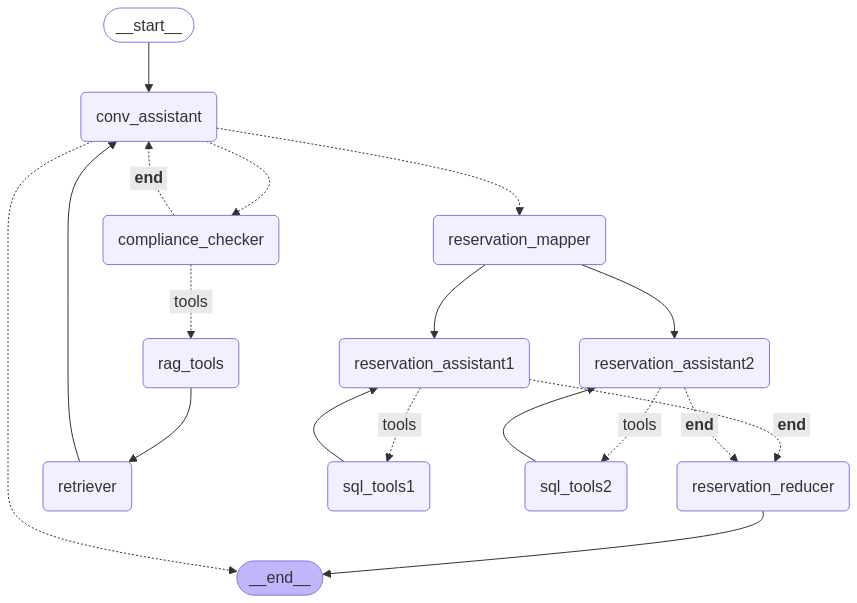

In [4]:
# Draw the graph
png = react_graph_with_memory.get_graph().draw_mermaid_png()
display(Image(png))

In [5]:
thread_id = 42  # Replace with the actual thread ID

# Example usage:
query = "Hey, I want to book a Family Suite from 14.04.2025 till 20.04.2025"

events = react_graph_with_memory.stream({"messages": [HumanMessage(content=query)], "confidence": [100]},
                                        config={"thread_id": thread_id},  # Pass the thread_id here
                                        stream_mode="values")

# iterate over the messages
for event in events:
    event["messages"][-1].pretty_print()
    message_content = event["messages"][-1].content
    if "Answer:" in message_content:
        final_answer = message_content.split("Answer:", 1)[1].strip()

================================ Human Message =================================

Hey, I want to book a Family Suite from 14.04.2025 till 20.04.2025
================================== Ai Message ==================================

Let me first check with our compliance checker to ensure everything is in order. Please hold on for a moment. 

[Forwarding to compliance_checker]
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_5HjCqjasauGMmImdgGnPqpYq)
 Call ID: call_5HjCqjasauGMmImdgGnPqpYq
  Args:
    query: booking a Family Suite from 14.04.2025 till 20.04.2025


================================= Tool Message =================================
Name: retrieve

Source: {}
Content: The system should refuse or redirect queries with:Illegal requests (e.g., falsifying documents, fraudulent bookings).Hate speech, harassment, or explicit threats toward individuals or groups.Offensive, obscene, or otherwise harmful content.Request of information about other guests. You cannot share there names or dates of stay
================================== Ai Message ==================================

I could not find any specific guidelines or regulations related to booking a Family Suite for the dates you mentioned (14.04.2025 to 20.04.2025). 

Since there are no applicable rules found, your request appears to be compliant. If you have any additional information or specific concerns, please let me know!
================================== Ai Message ==================================

Since you want to book a Family Suite from 14.04.2025 to 20.04.2025, I will forw

In [6]:
for message in react_graph_with_memory.get_state({"configurable": {"thread_id": thread_id}}).values["messages"]:
  print(message.content)

Hey, I want to book a Family Suite from 14.04.2025 till 20.04.2025
Let me first check with our compliance checker to ensure everything is in order. Please hold on for a moment. 

[Forwarding to compliance_checker]

Source: {}
Content: The system should refuse or redirect queries with:Illegal requests (e.g., falsifying documents, fraudulent bookings).Hate speech, harassment, or explicit threats toward individuals or groups.Offensive, obscene, or otherwise harmful content.Request of information about other guests. You cannot share there names or dates of stay
I could not find any specific guidelines or regulations related to booking a Family Suite for the dates you mentioned (14.04.2025 to 20.04.2025). 

Since there are no applicable rules found, your request appears to be compliant. If you have any additional information or specific concerns, please let me know!
Since you want to book a Family Suite from 14.04.2025 to 20.04.2025, I will forward your request to our reservation assistant 

In [48]:
# overall state class
class OverallState(TypedDict):
  messages: Annotated[list[BaseMessage], add_messages]
  messages_assistant_1: Annotated[list[BaseMessage], add_messages]
  messages_assistant_2: Annotated[list[BaseMessage], add_messages]
  confidence: Annotated[list[int], add]

def map_reservation_assistant(state: StateWithSelfAssessment) -> OverallState:
  """
   Node for Map part for parallel execution of Reservation ASSISTANTS

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     SharedStateTools: A dictionary mapping node names to states.
   """
  # For parallel execution, return a dictionary with keys being the target nodes
  # and values being the state to pass to each node

  shared_state = {"messages": state["messages"], "messages_assistant_1": state["messages"], "messages_assistant_2": state["messages"],
            "confidence": state["confidence"]}

  return shared_state


# SQL Agent node 1
def sql_assistant1(state: OverallState) -> OverallState:
  """
   SQL Assistant Agent

   Args:
     state (SharedStateTools): The current state of the conversation.

   Returns:
     SharedStateTools: The updated state of the conversation.
   """
  messages = state["messages_assistant_1"]

  date_today = datetime.now().strftime("%Y-%m-%d")

  confidence = state["confidence"]

  response = [llm_with_sql_tools1.invoke([sys_msg_sql] + messages)]

  return {"messages": state["messages"],
          "messages_assistant_1": response,
          "messages_assistant_2": state["messages_assistant_2"],
          "confidence": confidence}

# SQL Agent node 1
def sql_assistant1_sync(state: OverallState) -> OverallState:
   """
    A synchronisation node fot the first SQL Assistant Agent

    Args:
      state (SharedStateTools): The current state of the conversation.

    Returns:
      SharedStateTools: The updated state of the conversation.
   """
   return state

# SQL Agent node 2
def sql_assistant2(state: OverallState) -> OverallState:
  """
   SQL Assistant Agent

   Args:
     state (SharedStateTools): The current state of the conversation.

   Returns:
     SharedStateTools: The updated state of the conversation.
   """
  messages = state["messages_assistant_2"]

  date_today = datetime.now().strftime("%Y-%m-%d")

  confidence = state["confidence"]

  response = [llm_with_sql_tools2.invoke([sys_msg_sql] + messages)]

  return {"messages": state["messages"],
          "messages_assistant_2": response,
          "messages_assistant_1": state["messages_assistant_1"],
          "confidence": confidence}

# SQL Agent node 1
def sql_assistant2_sync(state: OverallState) -> OverallState:
   """
    A synchronisation node fot the seond SQL Assistant Agent

    Args:
      state (SharedStateTools): The current state of the conversation.

    Returns:
      SharedStateTools: The updated state of the conversation.
   """
   return state


def reduce_sql_results(state: OverallState) -> StateWithSelfAssessment:
  """
  Reduces/merges results from multiple SQL assistants.

  Args:
    states (SharedStateTools): Dictionary of states from different assistants.

  Returns:
    StateWithSelfAssessment: The merged state.
  """
  messages = state["messages"]

  message_dict_list = []

  merge_index = len(messages)

  message_1 = state.get("messages_assistant_1")[merge_index:]

  for message in message_1:
      message_dict = {}
      message_dict["message"] = message
      message_dict["priority"] = 1
      message_dict_list.append(message_dict)

  message_2 = state.get("messages_assistant_2")[merge_index:]

  for message in message_2:
      message_dict = {}
      message_dict["message"] = message
      message_dict["priority"] = 2
      message_dict_list.append(message_dict)

  message_dict_list.sort(key=lambda x: x["priority"])

  merger_sys_msg = SystemMessage(content=f"""
        You get the conversation with multiple reservation assistants trying to answer the user request. Please aggregate there answers intelligently:
          - Don't tell the user how many assistants there are
          - If any assistant cannot help then just ignore its answer
      """)


  return {"messages": [llm.invoke([merger_sys_msg] + messages + [x["message"] for x in message_dict_list])]+ [x["message"] for x in message_dict_list], "confidence": state.get("confidence")}

In [49]:
# Graph
builder = StateGraph(OverallState)

# Define nodes: these do the work
builder.add_node("conv_assistant", conv_assistant)
builder.add_node("reservation_mapper", map_reservation_assistant)
builder.add_node("reservation_assistant1", sql_assistant1)
builder.add_node("reservation_assistant2", sql_assistant2)
builder.add_node("reservation_reducer", reduce_sql_results)
builder.add_node("reservation_assistant1_sync", sql_assistant1_sync)
builder.add_node("reservation_assistant2_sync", sql_assistant2_sync)
builder.add_node("compliance_checker", rag_assistant)
builder.add_node("retriever", generate)
builder.add_node("sql_tools1", ToolNode(sql_tools1, messages_key="messages_assistant_1"))
builder.add_node("sql_tools2", ToolNode(sql_tools2, messages_key="messages_assistant_2"))
builder.add_node("rag_tools", ToolNode(rag_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "conv_assistant")
builder.add_conditional_edges(
    "conv_assistant",
    choose_next_node,
    path_map=["reservation_mapper", "compliance_checker", "__end__"])

# Map-reduce pattern for parallel execution
builder.add_edge("reservation_mapper", "reservation_assistant1")
builder.add_edge("reservation_mapper", "reservation_assistant2")
builder.add_edge("reservation_reducer", "__end__")

# Tool handling for SQL assistants
tools_condition_sql_1 = partial(tools_condition, messages_key="messages_assistant_1")
tools_condition_sql_2 = partial(tools_condition, messages_key="messages_assistant_2")
builder.add_conditional_edges("reservation_assistant1", tools_condition_sql_1, path_map={"tools": "sql_tools1", "__end__": "reservation_assistant1_sync"})
builder.add_conditional_edges("reservation_assistant2", tools_condition_sql_2, path_map={"tools": "sql_tools2", "__end__": "reservation_assistant2_sync"})
builder.add_edge(["reservation_assistant1_sync", "reservation_assistant2_sync"], "reservation_reducer")

# Compliance checker flow
builder.add_conditional_edges("compliance_checker", tools_condition, path_map={"tools": "rag_tools", "__end__": "conv_assistant"})
builder.add_edge("sql_tools1", "reservation_assistant1")
builder.add_edge("sql_tools2", "reservation_assistant2")
builder.add_edge("rag_tools", "retriever")
builder.add_edge("retriever", "conv_assistant")
react_graph_with_memory = builder.compile(checkpointer=memory)

In [50]:
thread_id = 76  # Replace with the actual thread ID

# Example usage:
query = "Hey, I want to book a Family Suite from 14.04.2025 till 20.04.2025"

events = react_graph_with_memory.stream({"messages": [HumanMessage(content=query)], "confidence": [100]},
                                        config={"thread_id": thread_id},  # Pass the thread_id here
                                        stream_mode="values")

# iterate over the messages
for event in events:
    event["messages"][-1].pretty_print()
    message_content = event["messages"][-1].content
    if "Answer:" in message_content:
        final_answer = message_content.split("Answer:", 1)[1].strip()

================================ Human Message =================================

Hey, I want to book a Family Suite from 14.04.2025 till 20.04.2025
================================== Ai Message ==================================

compliance_checker
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_5ci1rc1nbCRdSnFEIFl54mMy)
 Call ID: call_5ci1rc1nbCRdSnFEIFl54mMy
  Args:
    query: booking Family Suite regulations


================================= Tool Message =================================
Name: retrieve

Source: {}
Content: The system should refuse or redirect queries with:Illegal requests (e.g., falsifying documents, fraudulent bookings).Hate speech, harassment, or explicit threats toward individuals or groups.Offensive, obscene, or otherwise harmful content.Request of information about other guests. You cannot share there names or dates of stay
================================== Ai Message ==================================

To assess the compliance of booking a Family Suite from April 14, 2025, to April 20, 2025, I will need to check for any relevant guidelines or regulations regarding booking policies, availability, or restrictions for that period. Let me retrieve the pertinent information from the database. Please hold on for a moment.
================================== Ai Message ==================================

reservation_assistant
================================== Ai Message ==

In [51]:
for message in react_graph_with_memory.get_state({"configurable": {"thread_id": thread_id}}).values["messages"]:
  print(message)

content='Hey, I want to book a Family Suite from 14.04.2025 till 20.04.2025' additional_kwargs={} response_metadata={} id='8500af6d-6ee6-4f0f-92a6-3663df3a09ac'
content='compliance_checker' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 330, 'total_tokens': 334, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6dd05565ef', 'id': 'chatcmpl-BJL2ihhHP6htSpHFbFbNkiZNYy3aW', 'finish_reason': 'stop', 'logprobs': None} id='run-77ad1f2a-730e-4587-a10b-a56c816509b6-0' usage_metadata={'input_tokens': 330, 'output_tokens': 4, 'total_tokens': 334, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
content='' additional_kwargs={'tool_calls': [{'id': 'call_5ci1rc1nb

In [52]:
# let's put everything in a chat format

thread_id = 50

def chat_with_agent(react_graph_with_memory, thread_id):
  """
  Chat with the agent.

  Args:
    react_graph_with_memory (): The graph with the agent.
    thread_id (int): The ID of the thread.
  """
  while True:
      user_input = input("You: ")
      if user_input.lower() in ["quit", "exit"]:
          break

      events = react_graph_with_memory.stream(
          input={"messages": [HumanMessage(content=user_input)], "confidence": [100]},
          config={"thread_id": thread_id},
          stream_mode="values",
      )

      for event in events:
          event["messages"][-1].pretty_print()
          message_content = event["messages"][-1].content
          if "Answer:" in message_content:
              final_answer = message_content.split("Answer:", 1)[1].strip()
              print(f"Agent: {final_answer}")

chat_with_agent(react_graph_with_memory, thread_id)


You: Hey, how are you
================================ Human Message =================================

Hey, how are you
================================== Ai Message ==================================

Hello! I'm doing well, thank you for asking. How can I assist you today?
You: What can you help with?
================================ Human Message =================================

What can you help with?
================================== Ai Message ==================================

I can assist you with general inquiries about our hotel, such as information on facilities, amenities, and location details. If you need help with booking a room, I can guide you on the information required to proceed. Additionally, if you have any issues or concerns during your stay, I'm here to help resolve them. How may I assist you today?
You: Till when is the reeption open today?
================================ Human Message =================================

Till when is the reeption open today?

KeyboardInterrupt: Interrupted by user

In [53]:
for message in react_graph_with_memory.get_state({"configurable": {"thread_id": thread_id}}).values["messages"]:
  print(message.content)

Hey, how are you
Hello! I'm doing well, thank you for asking. How can I assist you today?
What can you help with?
Till when is the reeption open today?
Let me check that for you. Please hold on for a moment. 

Compliance_checker


In [55]:
from langchain_core.messages import trim_messages

for message in trim_messages(react_graph_with_memory.get_state({"configurable": {"thread_id": thread_id}}).values["messages"], token_counter=len, max_tokens=3):
  print(message.content)

What can you help with?
Till when is the reeption open today?
Let me check that for you. Please hold on for a moment. 

Compliance_checker


In [56]:
from langchain_core.messages import RemoveMessage

# Agent node
def conv_assistant(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
   """
   SQL Assistant Agent

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     StateWithSelfAssessment: The updated state of the conversation.
   """
   messages = state["messages"]

   confidence_check_sys_msg = SystemMessage(content=f"""Please rate how confident you are that ai assistant understands the user's request correctly from 0 to 100. Answer only with this number without any additional text.""")
   answer = llm.invoke([confidence_check_sys_msg] + messages).content

   confidence = 100

   if confidence > 80:
     if len(messages) > 4:
      ask_summary = HumanMessage(content=f"""Create a summary of the conversation above:""")
      summary = "Summary of previous conversation: "  + llm.invoke(messages[2:] + [ask_summary]).content
      response = llm.invoke([sys_msg_conversation] + messages).content

      final_response = AIMessage(content=response + "\n" + summary)

      return {"messages": [RemoveMessage(id=m.id) for m in messages[-2:]] + [final_response],
           "confidence": [confidence]}
     else:
      return {"messages": [llm.invoke([sys_msg_conversation] + messages)],
           "confidence": [confidence]}
   else:
     return {"messages": [llm.invoke([sys_msg_conversation] + add_messages(messages,
                                                                           AIMessage(content="You are extremely unsure. Please apologize for that and ask user to repeate everything")))],
             "confidence": [confidence]}

In [57]:
# Graph
builder = StateGraph(OverallState)

# Define nodes: these do the work
builder.add_node("conv_assistant", conv_assistant)
builder.add_node("reservation_mapper", map_reservation_assistant)
builder.add_node("reservation_assistant1", sql_assistant1)
builder.add_node("reservation_assistant2", sql_assistant2)
builder.add_node("reservation_reducer", reduce_sql_results)
builder.add_node("compliance_checker", rag_assistant)
builder.add_node("retriever", generate)
builder.add_node("sql_tools1", ToolNode(sql_tools1, messages_key="messages_assistant_1"))
builder.add_node("sql_tools2", ToolNode(sql_tools2, messages_key="messages_assistant_2"))
builder.add_node("rag_tools", ToolNode(rag_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "conv_assistant")
builder.add_conditional_edges(
    "conv_assistant",
    choose_next_node,
    path_map=["reservation_mapper", "compliance_checker", "__end__"])

# Map-reduce pattern for parallel execution
builder.add_edge("reservation_mapper", "reservation_assistant1")
builder.add_edge("reservation_mapper", "reservation_assistant2")
builder.add_edge("reservation_reducer", "__end__")

# Tool handling for SQL assistants
tools_condition_sql_1 = partial(tools_condition, messages_key="messages_assistant_1")
tools_condition_sql_2 = partial(tools_condition, messages_key="messages_assistant_2")
builder.add_conditional_edges("reservation_assistant1", tools_condition_sql_1, path_map={"tools": "sql_tools1", "__end__": "reservation_reducer"})
builder.add_conditional_edges("reservation_assistant2", tools_condition_sql_2, path_map={"tools": "sql_tools2", "__end__": "reservation_reducer"})

# Compliance checker flow
builder.add_conditional_edges("compliance_checker", tools_condition, path_map={"tools": "rag_tools", "__end__": "conv_assistant"})
builder.add_edge("sql_tools1", "reservation_assistant1")
builder.add_edge("sql_tools2", "reservation_assistant2")
builder.add_edge("rag_tools", "retriever")
builder.add_edge("retriever", "conv_assistant")
react_graph_with_memory = builder.compile(checkpointer=memory)

In [61]:
# let's put everything in a chat format

thread_id = 69

def chat_with_agent(react_graph_with_memory, thread_id):
  """
  Chat with the agent.

  Args:
    react_graph_with_memory (): The graph with the agent.
    thread_id (int): The ID of the thread.
  """
  while True:
      user_input = input("You: ")
      if user_input.lower() in ["quit", "exit"]:
          break

      events = react_graph_with_memory.stream(
          input={"messages": [HumanMessage(content=user_input)], "confidence": [100]},
          config={"thread_id": thread_id},
          stream_mode="values",
      )

      for event in events:
          event["messages"][-1].pretty_print()
          message_content = event["messages"][-1].content
          if "Answer:" in message_content:
              final_answer = message_content.split("Answer:", 1)[1].strip()
              print(f"Agent: {final_answer}")

chat_with_agent(react_graph_with_memory, thread_id)


You: Hey, how are you?
================================ Human Message =================================

Hey, how are you?
================================== Ai Message ==================================

Hello! I'm doing well, thank you for asking. How can I assist you today?
You: What can you do?
================================ Human Message =================================

What can you do?
================================== Ai Message ==================================

I can help you with a variety of inquiries related to our hotel services, such as providing information about our facilities, amenities, and location. I can also assist with booking rooms if you have specific details in mind. How can I assist you today?
You: Till what time is the reception open today?
================================ Human Message =================================

Till what time is the reception open today?
================================== Ai Message ==================================

Let me c

KeyboardInterrupt: Interrupted by user

In [64]:
for message in react_graph_with_memory.get_state({"configurable": {"thread_id": thread_id}}).values["messages"]:
  print(message.content)

Hey, how are you?
Hello! I'm doing well, thank you for asking. How can I assist you today?
What can you do?
I can assist you with general inquiries about our hotel services, facilities, and amenities, as well as help with booking rooms. If you have a specific question or need assistance with something, just let me know!
Summary of previous conversation: In the conversation, the user asks what I can do. I respond by indicating that I can assist with checking compliance with rules and regulations based on user queries. I invite the user to ask specific questions or request information on particular topics.
